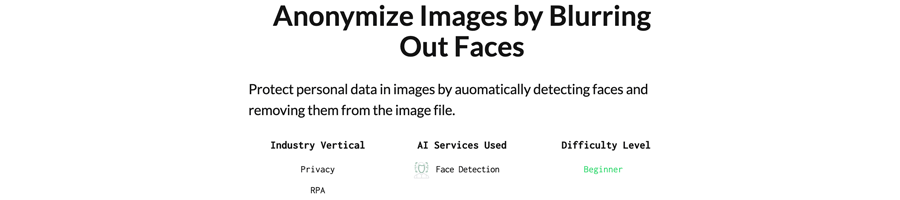

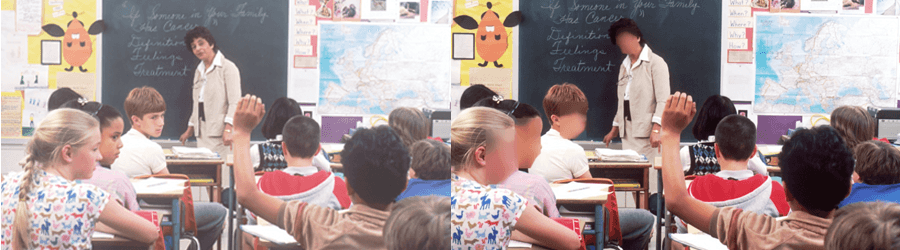

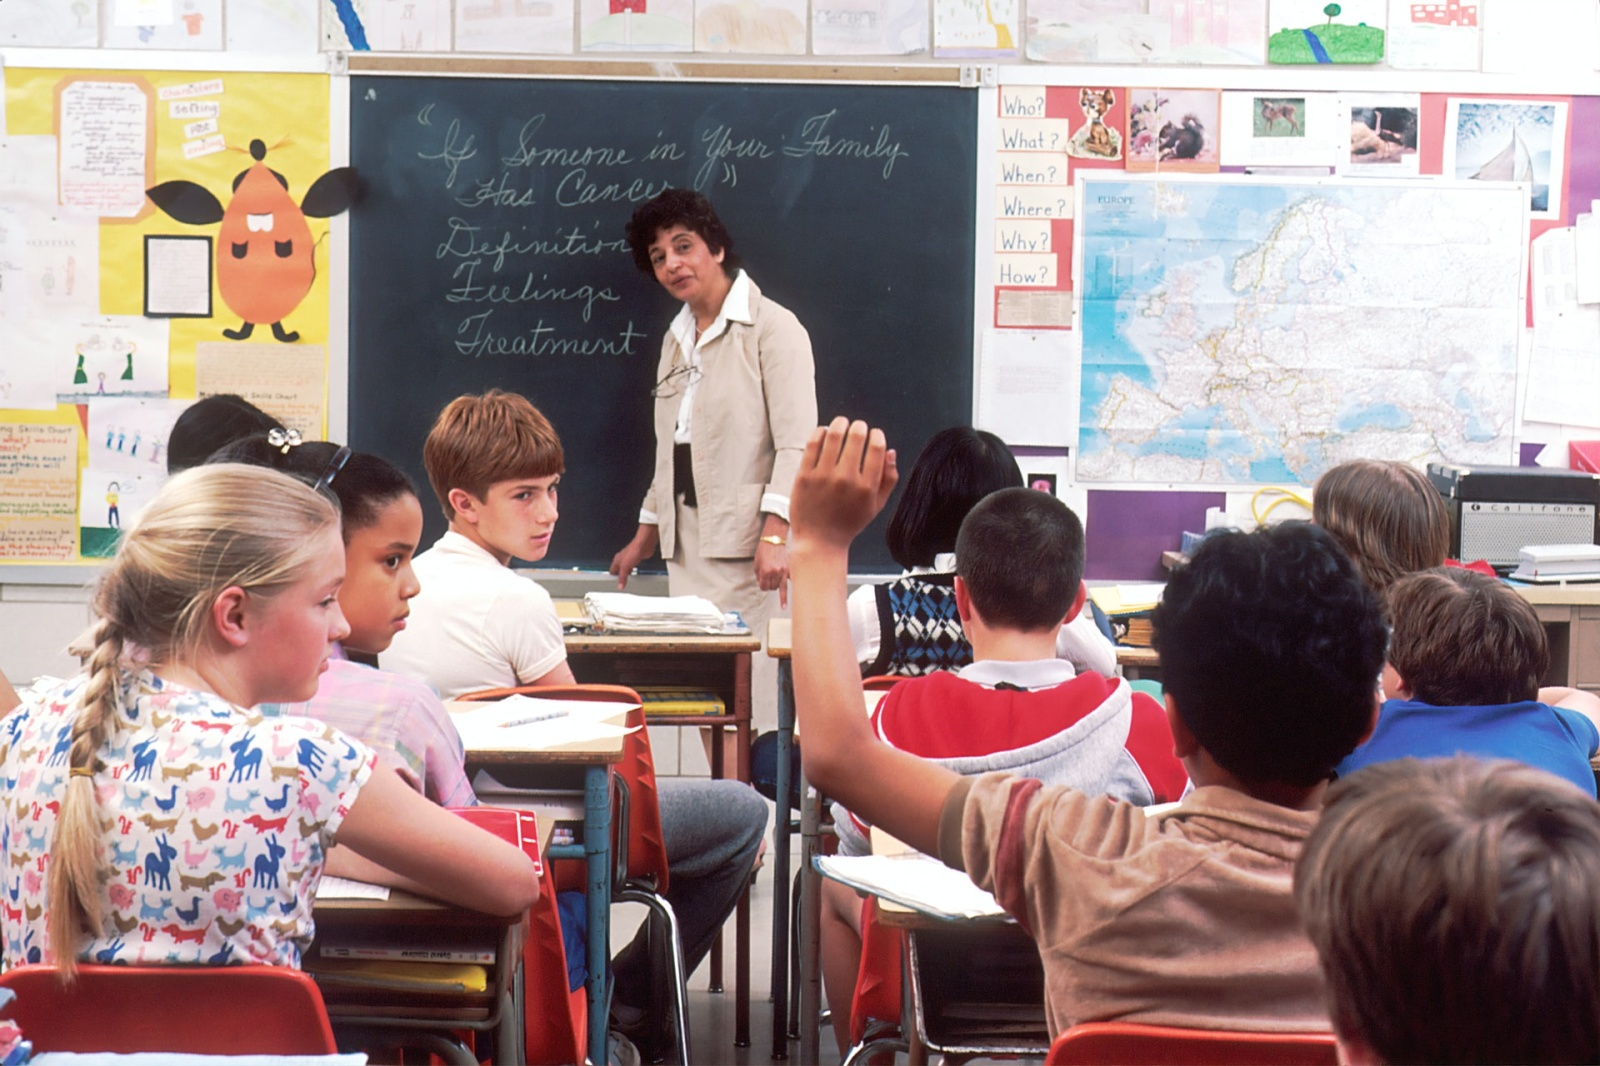

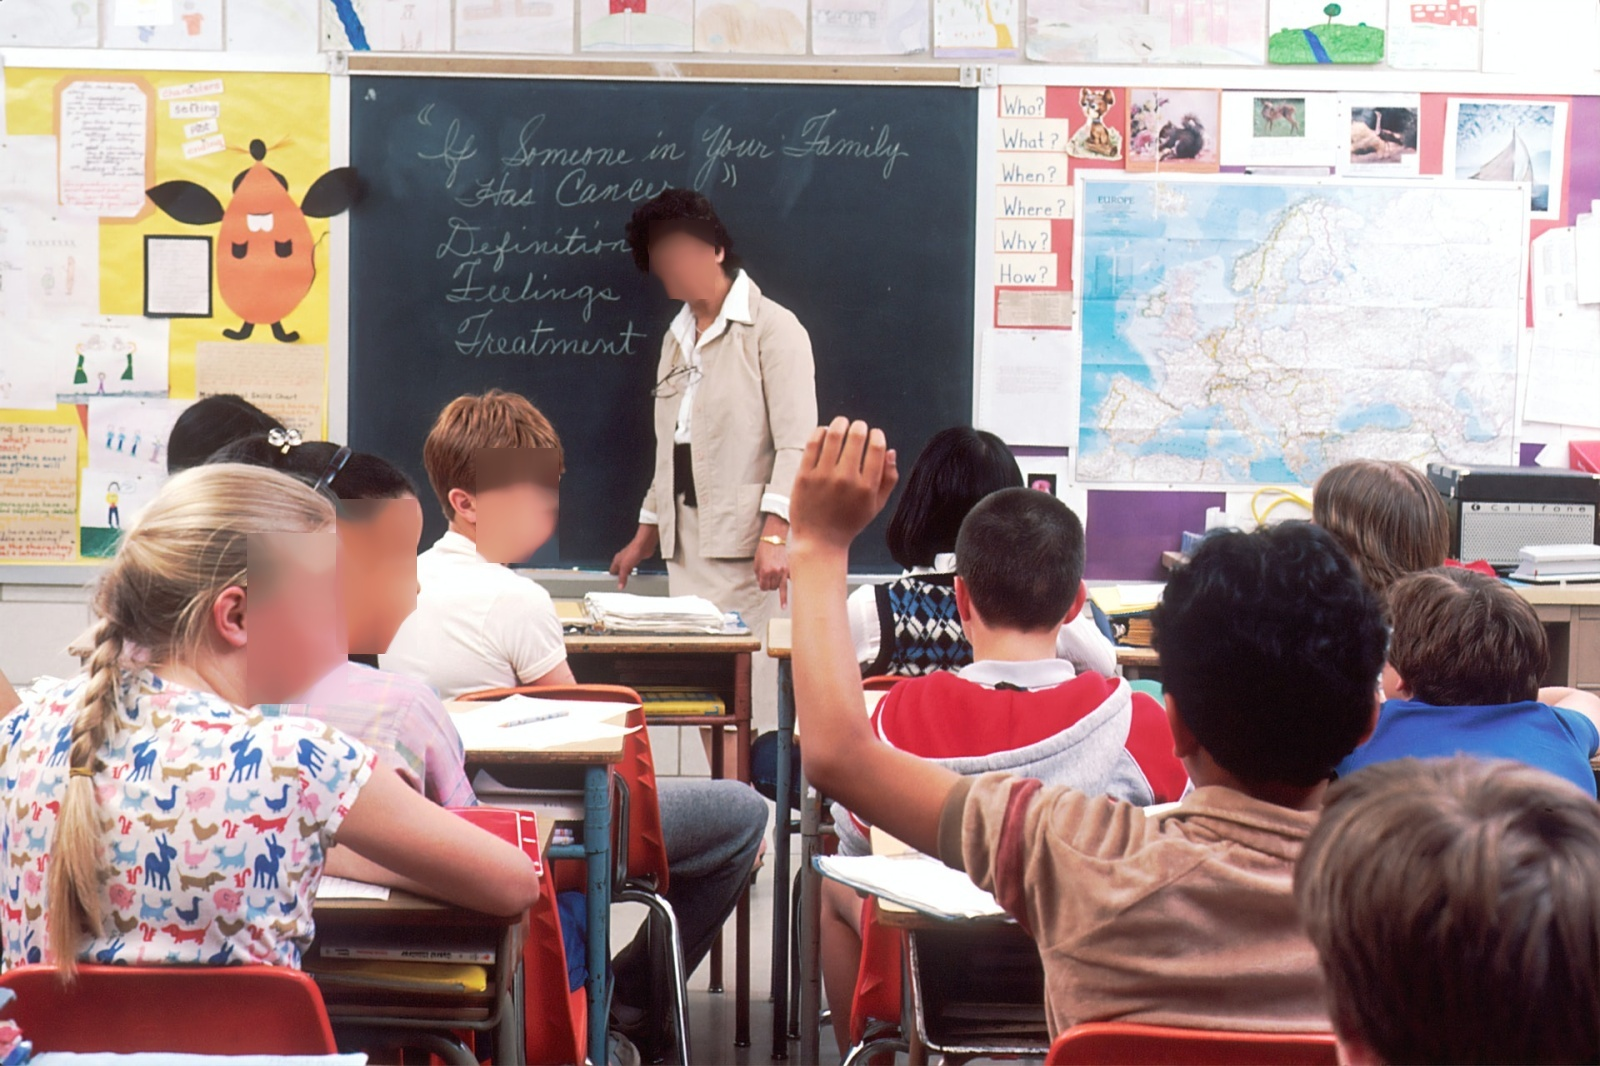

In [ ]:
#@markdown ## Upload Image
#@markdown ### Enter a file path:
#@markdown * Option A: Upload your own file on the left and specify file name.
#@markdown * Option B: Use `use-cases/blur-faces/assets/face_demo.jpg` for a sample image.
FILE_PATH = 'use-cases/blur-faces/assets/face_demo.jpg' #@param {type:"string"}
CONFIDENCE_LEVEL = 0.5 #@param {type:"slider", min:0, max:1, step:0.02}

#@markdown ---
#@markdown ### RAPYD.AI Parameters
#@markdown Enter your RAPYD.AI Account ID and Token (You can find both in your [dashboard](https://www.rapyd.ai/app/start). If you don't use RAPYD.AI yet, [sign up here](https://www.rapyd.ai/app/sign-up) free of charge.)

#@title RAPYD.AI API Settings
ACCOUNTID = 'your-accountid' #@param {type:"string"}
TOKEN = 'your-token' #@param {type:"string"}
PROVIDER = 'aws' #@param ["aws", "azure", "gcp"]

!git clone https://github.com/rapyd-ai/use-cases.git 2> /dev/null

# 0. Imports ----
import cv2
import json
import requests
from IPython.display import display, HTML, Image

# 1. Custom Functions ----
def scale_image(img, max_width=1600, max_height=1200):
  # Scales an cv2 image down if it is larger than the sepecified dimensions.
  img_width = img.shape[1]
  img_height = img.shape[0]

  if img_width >= img_height:
    if img_width > max_width:
      scale_target = max_width  
      width = scale_target
      height = int(img_height * scale_target / img_width)
      dim = (width, height)
      # resize image
      img = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)

  if img_width < img_height:
    if img_height > max_height:
      scale_target = max_height  
      height = scale_target
      width = int(img_width * scale_target / img_height)
      dim = (width, height)
      # resize image
      img = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
  return(img)

def get_face_bounding_boxes(response, min_confidence, img_height, img_width):
  # Returns all detected face bounding polies from the response object.
  # Img height and width needed to calculate bounding boxes from relative positioning.
  faces = json.loads(response.text.encode('utf8'))['result']
  face_bounding_boxes = []

  if json.loads(response.text.encode('utf8'))['meta']['provider'] == 'gcp':
    for i in faces:
      d = i['boundingPoly']
      y1 = min([e['y'] for e in d])
      y2 = max([e['y'] for e in d])
      x1 = min([e['x'] for e in d])
      x2 = max([e['x'] for e in d])
      bounding_box = {'y1': y1,
                'y2': y2,
                'x1': x1,
                'x2': x2}
      item = {'bounding_box': bounding_box, 
              'confidence': i['detectionConfidence']}
      face_bounding_boxes.append(item)
  
  if json.loads(response.text.encode('utf8'))['meta']['provider'] == 'aws':
    faces = faces['faceDetails']
    for i in faces:
      d = i['boundingBox']
      bounding_box = {'y1': round(d['top'] * img_width),
                'y2': round((d['top'] * img_width) + (d['height'] * img_width)),
                'x1': round(d['left'] * img_height),
                'x2': round((d['left'] * img_height) + (d['width'] * img_height))}
      item = {'bounding_box': bounding_box, 
              'confidence': i['confidence']}
      face_bounding_boxes.append(item)
  
  face_bounding_boxes = [d for d in face_bounding_boxes if d['confidence'] > min_confidence]
  return face_bounding_boxes

def blur_faces(file_input, file_output, face_bounding_boxes, blur_strength):
  # Reads an image from file, blurs faces and saves to disk.'
  img = cv2.imread(file_input, cv2.IMREAD_UNCHANGED)
  for i in face_bounding_boxes:
    y1 = i['bounding_box']['y1']
    y2 = i['bounding_box']['y2']
    x1 = i['bounding_box']['x1']
    x2 = i['bounding_box']['x2']
    img[y1:y2,x1:x2]=cv2.medianBlur(img[y1:y2,x1:x2],blur_strength)
  cv2.imwrite(file_output, img)

# 2. Data Preprocessing ----
img = scale_image(cv2.imread(FILE_PATH, cv2.IMREAD_UNCHANGED)) # Downscale image
img_width = img.shape[1]
img_height = img.shape[0]
cv2.imwrite("original-resized.jpg", img) # This will be sent to the API

# 3. RAPYD.AI API Call ----
url = "https://api.rapyd.ai/v1/vision/face"

payload = {}
files = [
  ('file', open('original-resized.jpg','rb'))
]
headers = {
  'PROVIDER': PROVIDER,
  'ACCOUNT-ID': ACCOUNTID,
  'Authorization': 'Bearer ' + TOKEN
}

response = requests.request("POST", url, headers=headers, data = payload, files = files)

# 3. Blur Faces ----
face_bounding_boxes = get_face_bounding_boxes(response, CONFIDENCE_LEVEL, img_width, img_height)
blur_faces('original-resized.jpg', 'blurred.jpg', face_bounding_boxes, 55)

# 4. Display Output ----
listOfImageNames = ['original-resized.jpg',
                    'blurred.jpg']

for imageName in listOfImageNames:
    display(HTML("<h2>" + imageName +"</h2>"), Image(filename=imageName, width = 500))

## What's next?

Experiment with different inputs and parameters.

Download the file `blurred.jpg` to your local computer to continue custom processing of the picture.

If you want to customize this Use Case even further, simply double click on the form and you will see the source code of this application. 

Copy, edit and share as you like.